## A2 - Utah Teapot Scan Converter and Z-Buffer

The teapot is cut off on the left due to negative coordinates in the JSON file. Code was originally added to "correct" this by offsetting the negative values such that they would all be positive, however, this change would have to be removed for the remaining assignments. When this assignment was refactored, the correction code was not included.

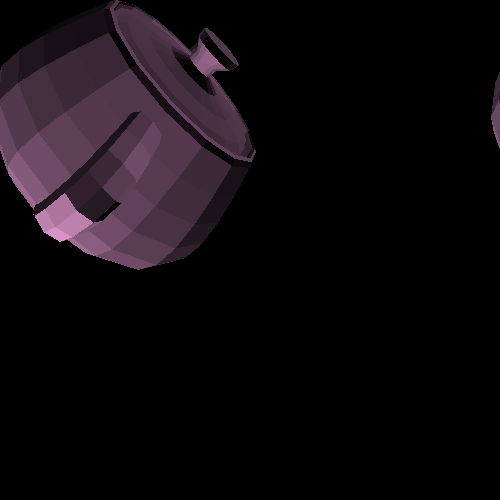

In [3]:
def main():
    teapot = Model("a2-teapot.json")

    canvas = Canvas()
    canvas.add_models([teapot])
    canvas.draw_models()

    display(canvas.im)

if __name__ == "__main__":
    main()

In [2]:
import json
import sys

import numpy as np
from PIL import Image


class Vertex:
    def __init__(self, vertex_json):
        # Vertex coordinates
        # Append the homogeneous coordinate
        self.v = np.concatenate((vertex_json["v"], [1]), dtype=np.float64)

        # Vertex normals
        self.n = np.array(vertex_json["n"], dtype=np.float64)

        # Texture coordinate
        self.t = np.array(vertex_json["t"], dtype=np.float64)


class Triangle:
    def __init__(self, triangle_json: object):
        self.vertices = []
        for _, vertex_json in triangle_json.items():
            self.vertices.append(Vertex(vertex_json))

        self.x_min = min(self.vertices, key=lambda vertex: vertex.v[0]).v[0]
        self.x_max = max(self.vertices, key=lambda vertex: vertex.v[0]).v[0]
        self.y_min = min(self.vertices, key=lambda vertex: vertex.v[1]).v[1]
        self.y_max = max(self.vertices, key=lambda vertex: vertex.v[1]).v[1]

        self.compute_color()

    def compute_color(self):
        dot_p = np.dot([0.707, 0.5, 0.5], self.vertices[0].n)

        if dot_p < 0:
            dot_p *= -1
        elif dot_p > 1.0:
            dot_p = 1.0

        self.color = (
            int(0.95 * dot_p * 255),
            int(0.65 * dot_p * 255),
            int(0.88 * dot_p * 255),
        )

        self.color = tuple((255 * np.dot([0.95, 0.65, 0.88], dot_p)).astype(int))

    def f01(self, x: np.float64, y: np.float64):
        return (
            (self.vertices[0].v[1] - self.vertices[1].v[1]) * x
            + (self.vertices[1].v[0] - self.vertices[0].v[0]) * y
            + (self.vertices[0].v[0] * self.vertices[1].v[1])
            - (self.vertices[1].v[0] * self.vertices[0].v[1])
        )

    def f12(self, x: np.float64, y: np.float64):
        return (
            (self.vertices[1].v[1] - self.vertices[2].v[1]) * x
            + (self.vertices[2].v[0] - self.vertices[1].v[0]) * y
            + (self.vertices[1].v[0] * self.vertices[2].v[1])
            - (self.vertices[2].v[0] * self.vertices[1].v[1])
        )

    def f20(self, x: np.float64, y: np.float64):
        return (
            (self.vertices[2].v[1] - self.vertices[0].v[1]) * x
            + (self.vertices[0].v[0] - self.vertices[2].v[0]) * y
            + (self.vertices[2].v[0] * self.vertices[0].v[1])
            - (self.vertices[0].v[0] * self.vertices[2].v[1])
        )


class Model:
    def __init__(self, model_file_name: str):
        model_file = open(model_file_name)
        self.model_json = json.load(model_file)
        self.triangles = []

        for triangle_json in self.model_json["data"]:
            self.triangles.append(Triangle(triangle_json))


class Canvas:
    def __init__(self, width: int = 500, height: int = 500):
        self.width = width
        self.height = height

        self.models: list[Model] = []

        self.im = Image.new("RGB", (self.width, self.height))
        self.z_buffer: list[list[float]] = [
            [sys.float_info.max for _ in range(self.width)] for _ in range(self.height)
        ]

    def add_models(self, models: list[Model] = []):
        for model in models:
            self.models.append(model)

    def draw_models(self):
        for model in self.models:
            for triangle in model.triangles:
                self.draw_triangle(triangle)

    def draw_triangle(self, triangle: Triangle):
        x_min = int(triangle.x_min)
        x_max = int(triangle.x_max)
        y_min = int(triangle.y_min)
        y_max = int(triangle.y_max)

        for y in range(y_min, y_max + 1):
            for x in range(x_min, x_max + 1):
                alpha = triangle.f12(x, y) / triangle.f12(
                    triangle.vertices[0].v[0], triangle.vertices[0].v[1]
                )
                beta = triangle.f20(x, y) / triangle.f20(
                    triangle.vertices[1].v[0], triangle.vertices[1].v[1]
                )
                gamma = triangle.f01(x, y) / triangle.f01(
                    triangle.vertices[2].v[0], triangle.vertices[2].v[1]
                )

                if alpha >= 0 and beta >= 0 and gamma >= 0:
                    z = (
                        alpha * triangle.vertices[0].v[2]
                        + beta * triangle.vertices[1].v[2]
                        + gamma * triangle.vertices[2].v[2]
                    )
                    if z < self.z_buffer[y][x]:
                        self.im.putpixel((x, y), triangle.color)
                        self.z_buffer[y][x] = z